In [36]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [37]:
def pad_and_crop(img, target_size=(45, 45), threshold=10):
    h, w = img.shape
    non_zero_rows = np.where(np.max(img, axis=1) > threshold)[0]
    non_zero_cols = np.where(np.max(img, axis=0) > threshold)[0]
    if len(non_zero_rows) > 0 and len(non_zero_cols) > 0:
        img = img[non_zero_rows[0]:non_zero_rows[-1]+1,
                  non_zero_cols[0]:non_zero_cols[-1]+1]
    h, w = img.shape
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = max(1, int(h * scale)), max(1, int(w * scale))
    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    square = np.zeros(target_size, dtype=np.uint8)
    y_off = (target_size[0] - new_h) // 2
    x_off = (target_size[1] - new_w) // 2
    square[y_off:y_off+new_h, x_off:x_off+new_w] = img
    return square

def invert_if_needed(img):
    return cv2.bitwise_not(img) if np.mean(img) > 127 else img

def show_image(img, title=None):
    plt.figure(figsize=(10, 3))
    plt.imshow(img, cmap='gray')
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

# Загрузка данных

In [38]:
class DataLoader:
    def __init__(self, data_dir="data", image_size=32):
        self.data_dir = data_dir
        self.image_size = image_size
        self.label_map = None
        self.classes = None

    def load_data(self):
        X, y = [], []
        self.classes = sorted([cls for cls in os.listdir(self.data_dir) if not cls.startswith('.')])
        self.label_map = {cls: i for i, cls in enumerate(self.classes)}

        for cls in self.classes:
            folder = os.path.join(self.data_dir, cls)
            for fname in sorted(os.listdir(folder)):
                path = os.path.join(folder, fname)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is None or img.size == 0:
                    continue
                img = invert_if_needed(img)
                img = pad_and_crop(img, target_size=(self.image_size, self.image_size))
                X.append(img.flatten())
                y.append(self.label_map[cls])
        
        X = np.array(X)
        y = np.array(y)
        print(f"Загружено изображений: {len(X)}")
        return X, y, self.classes

# Классификация

In [39]:
class KNNRecognizer:
    def __init__(self, image_size=32):
        self.models = {}
        self.accuracies = {}
        self.classes = None
        self.image_size = image_size
        self.best_k = None

    def train(self, X, y, classes, test_size=0.15):
        self.classes = classes
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=42
        )

        n_total = len(X)
        n_train = len(X_train)
        n_test = len(X_test)
        
        print(f"--- Разделение данных для обучения и валидации ---")
        print(f"Всего изображений: {n_total}")
        print(f"На обучение (85%): {n_train} изображений")
        print(f"На тестирование/валидацию (15%): {n_test} изображений")

        best_acc = 0
        
        for k in [1, 3, 5, 7, 9]:
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(X_train, y_train)
            
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            
            self.models[k] = model
            self.accuracies[k] = acc
            
            print(f"K={k}, точность на валидации: {acc:.4f}")
            
            if acc > best_acc:
                best_acc = acc
                self.best_k = k
        
        print(f"--- Лучшая модель по валидации: k={self.best_k} (acc={best_acc:.4f}) ---")

    def predict_all_models(self, img):
        img = invert_if_needed(img)
        img = pad_and_crop(img, target_size=(self.image_size, self.image_size))
        vec = img.flatten().reshape(1, -1)
        
        predictions = {}
        for k, model in self.models.items():
            label_idx = model.predict(vec)[0]
            predictions[k] = self.classes[label_idx]
            
        return predictions

# Генерация тестов

In [40]:
class SequenceGenerator:
    def __init__(self, data_dir="data", padding=5):
        self.data_dir = data_dir
        self.classes = sorted([cls for cls in os.listdir(data_dir) if not cls.startswith('.')])
        self.padding = padding

    def generate(self, length=6):
        chosen_classes = random.choices(self.classes, k=length)
        images = []
        for cls in chosen_classes:
            folder = os.path.join(self.data_dir, cls)
            fname = random.choice(os.listdir(folder))
            img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
            images.append(img)
        
        total_width = sum(img.shape[1] for img in images) + self.padding * (len(images)-1)
        max_height = max(img.shape[0] for img in images)
        result = np.ones((max_height, total_width), dtype=np.uint8) * 255
        x_offset = 0
        for img in images:
            h, w = img.shape
            y_offset = (max_height - h) // 2
            result[y_offset:y_offset+h, x_offset:x_offset+w] = img
            x_offset += w + self.padding
        
        show_image(result, title="Сгенерированная последовательность")
        print("Сгенерированные символы:", chosen_classes)
        return result, chosen_classes

# Сегментация

In [41]:
class Segmenter:
    def __init__(self, target_size=45, min_area=30, pad=4, draw_boxes=True):
        self.target_size = target_size
        self.min_area = min_area
        self.pad = pad
        self.draw_boxes = draw_boxes

    def segment(self, img):
        orig = img.copy()
        img = invert_if_needed(img)

        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresh = cv2.dilate(thresh, np.ones((2,2), np.uint8), 1)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        crops = []
        coords = []
        H, W = img.shape

        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if w*h < self.min_area:
                continue
            
            x0 = max(0, x - self.pad)
            y0 = max(0, y - self.pad)
            x1 = min(W, x + w + self.pad)
            y1 = min(H, y + h + self.pad)
            
            crop = pad_and_crop(img[y0:y1, x0:x1], (self.target_size, self.target_size))
            crops.append((x0, crop))
            coords.append((x0, y0, x1, y1))

        crops.sort(key=lambda t: t[0])
        coords = [c for _, c in sorted(zip([c[0] for c in coords], coords))]

        print(f"Найдено сегментов: {len(crops)}")

        if self.draw_boxes:
            boxed = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
            for (x0, y0, x1, y1) in coords:
                cv2.rectangle(boxed, (x0, y0), (x1, y1), (255, 0, 0), 2)
            show_image(boxed, title="Сегменты, выделенные прямоугольниками")

        for i, (_, c) in enumerate(crops):
            show_image(c, title=f"Сегмент {i+1}")

        return [c for _, c in crops]

Загружено изображений: 225291
--- Разделение данных для обучения и валидации ---
Всего изображений: 225291
На обучение (85%): 191497 изображений
На тестирование/валидацию (15%): 33794 изображений
K=1, точность на валидации: 0.9936
K=3, точность на валидации: 0.9379
K=5, точность на валидации: 0.7924
K=7, точность на валидации: 0.7452
K=9, точность на валидации: 0.7181
--- Лучшая модель по валидации: k=1 (acc=0.9936) ---


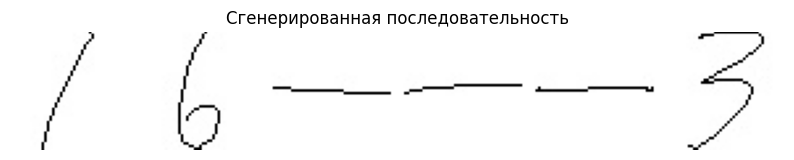

Сгенерированные символы: [',', '6', '-', '-', '-', '3']
Найдено сегментов: 6


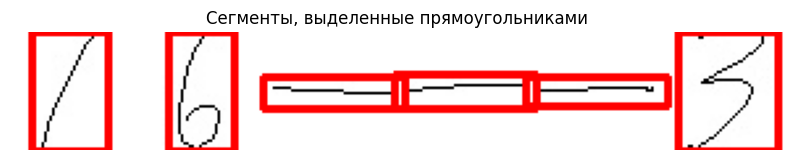

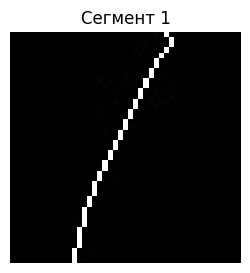

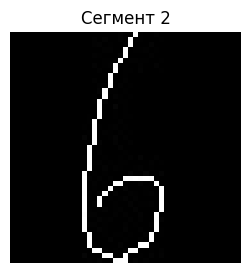

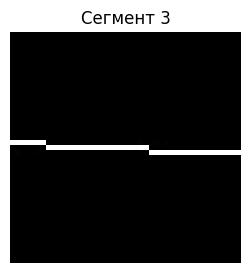

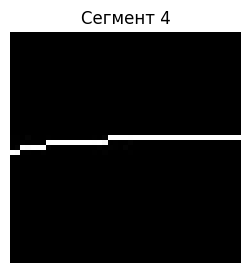

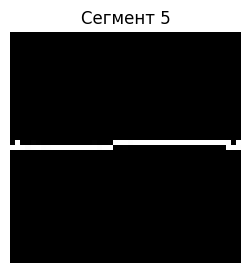

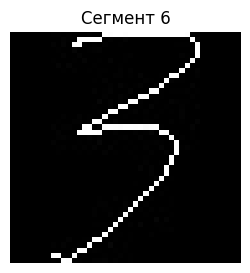


--- РЕЗУЛЬТАТЫ РАСПОЗНАВАНИЯ ---
Правильная последовательность: [',', '6', '-', '-', '-', '3']
K     | Точность (seq)  | Предсказание
------------------------------------------------------------
1     | 1.00 (6/6)   | [',', '6', '-', '-', '-', '3'] (Best on train)
3     | 1.00 (6/6)   | [',', '6', '-', '-', '-', '3']
5     | 1.00 (6/6)   | [',', '6', '-', '-', '-', '3']
7     | 1.00 (6/6)   | [',', '6', '-', '-', '-', '3']
9     | 1.00 (6/6)   | [',', '6', '-', '-', '-', '3']


In [42]:
loader = DataLoader(data_dir="data", image_size=45)
X, y, classes = loader.load_data()

recognizer = KNNRecognizer(image_size=45)
recognizer.train(X, y, classes)

gen = SequenceGenerator(data_dir="data", padding=5)
seq_img, seq_labels = gen.generate(length=6)

segmenter = Segmenter(target_size=45, draw_boxes=True)
segments = segmenter.segment(seq_img)

if len(segments) != len(seq_labels):
    print(f"ВНИМАНИЕ: Сгенерировано {len(seq_labels)} символов, а найдено {len(segments)} сегментов!")
    min_len = min(len(segments), len(seq_labels))
    segments = segments[:min_len]
    seq_labels = seq_labels[:min_len]


final_results = {k: [] for k in recognizer.models.keys()}

print("\n--- РЕЗУЛЬТАТЫ РАСПОЗНАВАНИЯ ---")
print(f"Правильная последовательность: {seq_labels}")

for i, seg in enumerate(segments):
    preds_dict = recognizer.predict_all_models(seg)

    for k, pred_label in preds_dict.items():
        final_results[k].append(pred_label)

print(f"{'K':<5} | {'Точность (seq)':<15} | {'Предсказание'}")
print("-" * 60)

for k in sorted(final_results.keys()):
    predicted_seq = final_results[k]
    
    correct_count = sum(1 for p, g in zip(predicted_seq, seq_labels) if p == g)
    seq_acc = correct_count / len(seq_labels) if len(seq_labels) > 0 else 0

    is_best_training = " (Best on train)" if k == recognizer.best_k else ""
    
    print(f"{k:<5} | {seq_acc:.2f} ({correct_count}/{len(seq_labels)})   | {predicted_seq}{is_best_training}")